<a href="https://colab.research.google.com/github/Sri-15B/Global-Energy-Forecasting-Competition-GEFCom-/blob/main/GEFCom_Energy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install pandas numpy matplotlib scikit-learn

In [2]:
from google.colab import files
uploaded = files.upload()

Saving PJMW_hourly.csv to PJMW_hourly.csv
Saving DAYTON_hourly.csv to DAYTON_hourly.csv
Saving COMED_hourly.csv to COMED_hourly.csv
Saving AEP_hourly.csv to AEP_hourly.csv
Saving DOM_hourly.csv to DOM_hourly.csv


In [4]:
import pandas as pd

# Load the dataset (example with AEP)
aep = pd.read_csv("AEP_hourly.csv")

# Convert Datetime column
aep['Datetime'] = pd.to_datetime(aep['Datetime'])

# Set Datetime as index
aep = aep.set_index('Datetime')

# Resample to daily average
aep = aep.resample('D').mean()

# Drop missing values
aep = aep.dropna()

In [5]:
# -----------------------------------------------
# STEP 4: BUILD, TRAIN & EVALUATE THE MODEL
# -----------------------------------------------

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# ----- 1. Create time-based features -----
aep['Day'] = aep.index.day
aep['Month'] = aep.index.month
aep['Year'] = aep.index.year
aep['DayOfWeek'] = aep.index.dayofweek

# Optionally add lag features (previous day’s load)
aep['Prev_Day_Load'] = aep['AEP_MW'].shift(1)
aep = aep.dropna()

# ----- 2. Define features (X) and target (y) -----
X = aep[['Day', 'Month', 'Year', 'DayOfWeek', 'Prev_Day_Load']]
y = aep['AEP_MW']

# ----- 3. Split the data into train and test sets -----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# ----- 4. Initialize and train Random Forest Regressor -----
model = RandomForestRegressor(
    n_estimators=200,        # number of trees
    max_depth=10,            # limit tree depth
    random_state=42,         # for reproducibility
    n_jobs=-1                # use all CPU cores
)

model.fit(X_train, y_train)

# ----- 5. Make predictions -----
y_pred = model.predict(X_test)

# ----- 6. Evaluate model performance -----
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Random Forest Regressor Performance:")
print("------------------------------------")
print(f"R² Score       : {r2:.4f}")
print(f"MAE (MW)       : {mae:.2f}")
print(f"RMSE (MW)      : {rmse:.2f}")

# ----- 7. Display sample results -----
comparison = pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred[:10]
})
print("\nSample Predictions:")
print(comparison)

Random Forest Regressor Performance:
------------------------------------
R² Score       : 0.8080
MAE (MW)       : 607.02
RMSE (MW)      : 798.24

Sample Predictions:
         Actual     Predicted
0  13596.416667  13827.783959
1  13321.541667  13723.865373
2  13729.291667  13615.650681
3  12783.916667  12544.466320
4  11654.040000  13002.033095
5  13259.333333  13378.691381
6  13406.375000  13689.465389
7  13184.208333  13659.807633
8  13460.041667  13480.919727
9  13135.125000  13401.100648


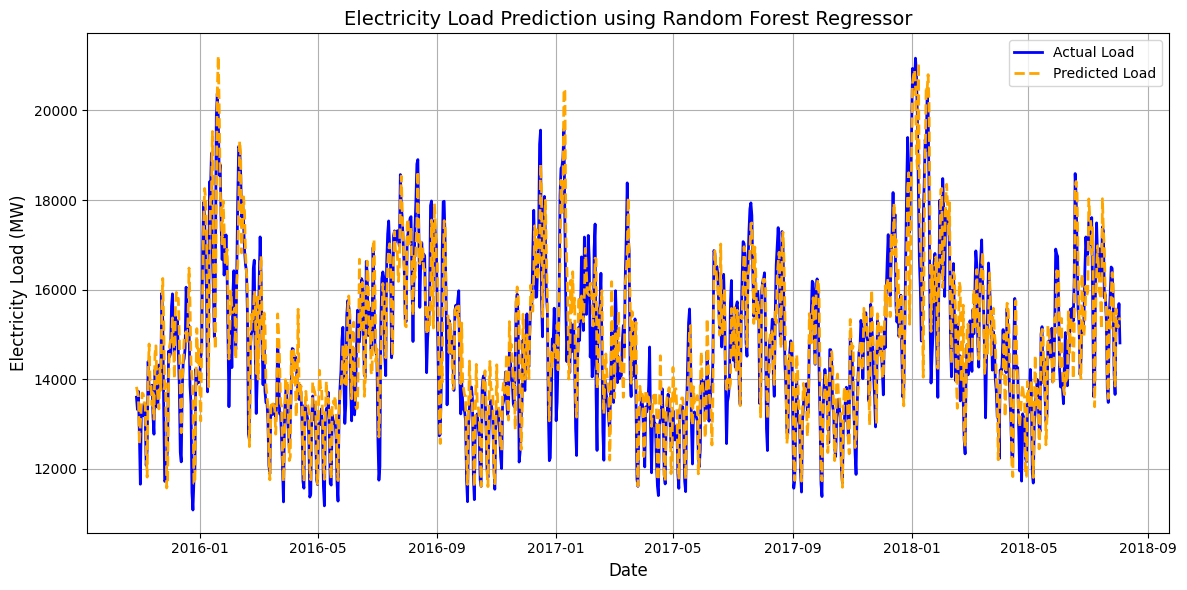

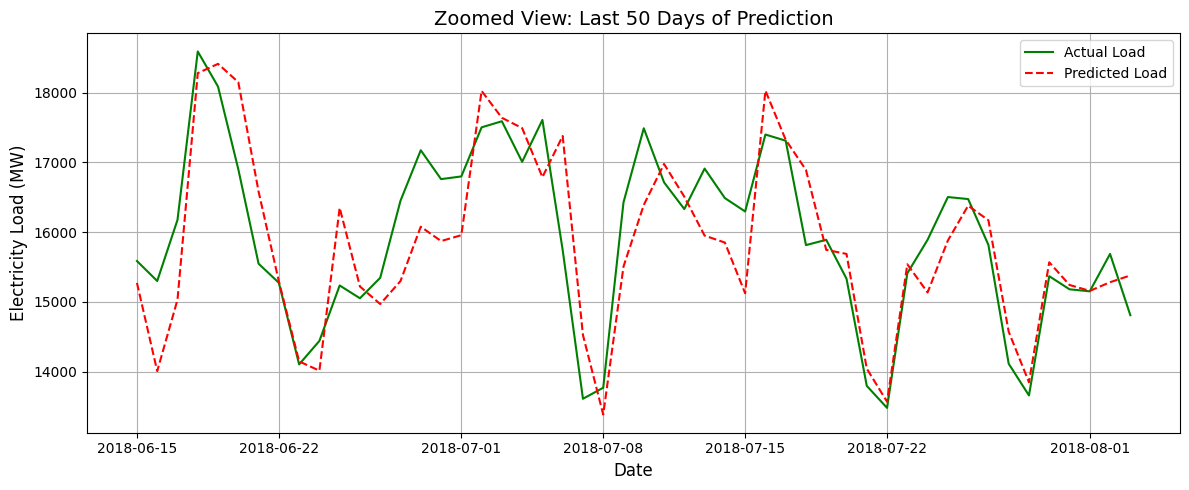

In [6]:
# -----------------------------------------------
# STEP 5: VISUALIZE MODEL PREDICTIONS
# -----------------------------------------------

import matplotlib.pyplot as plt

# Convert test index to a proper datetime series
test_index = y_test.index

# Plot actual vs predicted values
plt.figure(figsize=(12,6))
plt.plot(test_index, y_test, label='Actual Load', color='blue', linewidth=2)
plt.plot(test_index, y_pred, label='Predicted Load', color='orange', linestyle='--', linewidth=2)
plt.title("Electricity Load Prediction using Random Forest Regressor", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Electricity Load (MW)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------
# Optional: Zoom in to view a smaller time range
# -----------------------------------------------
plt.figure(figsize=(12,5))
plt.plot(test_index[-50:], y_test[-50:], label='Actual Load', color='green')
plt.plot(test_index[-50:], y_pred[-50:], label='Predicted Load', color='red', linestyle='--')
plt.title("Zoomed View: Last 50 Days of Prediction", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Electricity Load (MW)", fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()